# Pseudotime using spectral embedding

In [1]:
%matplotlib inline
import numpy as np
import math
from numpy.matlib import repmat
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
from scipy.interpolate import UnivariateSpline
from OscopeBootstrap.pseudotime import estimate_pseudotime_using_spectral_embedding, calculate_metrics, \
    plot_latent_space, plot_latent_space_notrue, plot_gene_fits, plot_gene_fits_notrue, plot_correspondence_of_peaktime_and_times

## Load data

In [2]:
case='D0'
alpha='0.2'
path_to_data = '../Glioblastoma_project/OsconetInput/'
path_to_comm = '../Glioblastoma_project/Results/'
path_to_fig='../Glioblastoma_project/Plots/'

datafile=f'{path_to_data}filter{case}_{alpha}.csv'
data=pd.read_csv(datafile,header=0, index_col=0)

In [3]:
data

,X125_1_5,X125_1_6,X125_1_9,X125_1_14,X125_1_28,X125_1_53,X125_1_68,X125_1_69,X125_1_88,X125_1_89,...,X125_2_747,X125_2_754,X125_2_769,X125_2_794,X125_2_801,X125_2_802,X125_2_804,X125_2_808,X125_2_813,X125_2_826
ENO1,-0.696559,-1.000000,-0.729014,0.142273,1.000000,0.602283,-0.631817,-0.473172,-0.462235,-0.485557,...,0.711017,-0.434861,0.839312,-0.196405,-0.650477,0.226190,-1.000000,-0.551442,0.403019,-0.422884
CDC42,1.000000,0.770572,-0.704478,-1.000000,-0.116515,-1.000000,-0.196961,1.000000,0.172911,-0.775591,...,-0.626813,-0.178255,-0.382816,0.314533,-0.237660,-1.000000,-0.137566,-0.347771,-1.000000,-0.370631
STMN1,-0.496055,0.685229,-0.156167,-0.525739,-0.579550,-1.000000,-0.235669,-1.000000,-1.000000,-0.572816,...,-0.289601,-1.000000,-0.118847,-0.165886,-1.000000,0.272758,-1.000000,-0.379209,-1.000000,0.797099
IFI6,-0.385937,-0.178611,-0.451616,1.000000,-0.590141,-0.536789,-0.627461,0.066121,-0.455873,-1.000000,...,-0.307496,0.143651,-0.141043,-0.593449,-0.292683,-0.379651,-1.000000,-0.092271,-1.000000,-1.000000
ATPIF1,0.551716,-0.481094,-0.307125,-1.000000,0.553551,-0.414740,-0.058606,-1.000000,-0.312505,0.315361,...,0.749935,-0.518339,-0.638241,-1.000000,0.787367,1.000000,-1.000000,-1.000000,-0.103168,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND3,-0.472082,-0.624964,-0.572594,0.217955,0.352953,0.307830,-0.761785,-1.000000,-0.747599,-0.173557,...,-0.828439,-0.179124,0.637946,-0.936271,1.000000,-0.933626,-0.787832,-0.709244,-0.821913,0.672052
MT-ND4L,-0.831013,-1.000000,-0.622718,0.431301,-0.436044,-0.362632,0.281511,-1.000000,-0.251295,-0.140517,...,-0.761783,-0.475455,-0.409048,-0.160893,1.000000,-1.000000,-1.000000,-0.583662,-0.023320,1.000000
MT-ND4,-0.882673,-0.806836,-0.547807,0.369044,-0.261600,0.564617,-0.377488,-0.784516,-0.416080,-0.306251,...,-0.753684,-0.318812,-0.317730,-0.944942,1.000000,-1.000000,-0.725097,-0.761304,-0.962136,0.345336
MT-ND5,-0.425150,-1.000000,-0.286992,0.683081,0.065795,0.927252,0.162498,-0.445533,-0.434022,-0.675140,...,-1.000000,-0.206948,-0.106549,-0.788561,1.000000,-1.000000,-0.167680,-1.000000,-1.000000,-0.392607


## load community info

In [4]:
commDataFile=f'{path_to_comm}{case}_{alpha}Comm.csv'
commReportFile=f'{path_to_comm}Report{case}_{alpha}.csv'
commData = pd.read_csv(commDataFile,header=0, index_col=1)
commData=commData[['CommunityID']]
genelist=commData.index.values
ncomm=commData.max()
commInfo=pd.read_csv(commReportFile,header=0, index_col=1)
print(commReportFile)

../Glioblastoma_project/Results/ReportD0_0.2.csv


In [5]:
commInfo=commInfo.sort_index()


In [7]:
#commInfo

In [8]:
communities=commInfo.index.values
currentCFlag=commInfo.loc[communities==1,'LinFlag']
print(currentCFlag.values)
#selecting  linear clusters:

Linear=commInfo[commInfo.LinFlag==1]
LinearId=Linear.index.values
#selecting  non linear clusters:
print('Linear Communities')
print(LinearId)
NonLinear=commInfo[commInfo.LinFlag==0]
NonLinearId=NonLinear.index.values
print('Non Linear Communities')
print(NonLinearId)

[0]
Linear Communities
[ 4  5  7  8 16 18 23 25 26 27]
Non Linear Communities
[ 1  2  3  6  9 10 11 12 13 14 15 17 19 20 21 22 24 28]


# Get data for the community of interest - Linear Case

In [366]:
#Start from the linear communities
commId=LinearId[4]
Flag="Linear"
#communities=commInfo.index.values
#currentCFlag=commInfo.loc[communities==commId,'LinFlag']
comm = commData[commData.CommunityID == commId]
#select ONLY the genes in the selected community to use laterin the plot
genelist=comm.index.values

In [367]:
training_data=data.loc[comm.index]
nsamp=training_data.shape[1]
n_neighbors=math.ceil(nsamp/10)
n_neighbors
#n_neighbors=3 ####How to chose the number of neughbours?

27

### Spectral pseudotime time


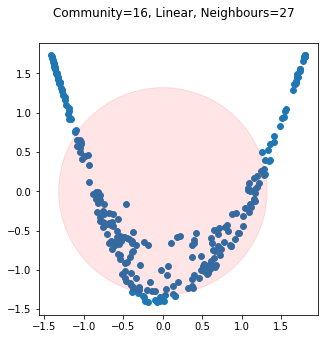

In [368]:
pt_spectral, latent_space_2d = estimate_pseudotime_using_spectral_embedding(training_data.T, n_neighbors)
[fig, ax] = plot_latent_space_notrue(latent_space_2d)
PseudoTimefile=f'{path_to_fig}LinearPseudotime{case}_{alpha}_comm_{commId}.pdf'

pt = PdfPages(PseudoTimefile)
fig.suptitle("Community="+str(commId) + ", "+ Flag + ', Neighbours=' +str(n_neighbors))
fig
pt.savefig(fig)

pt.close()

## Select genes to plot

You can modify `geneplot` to plot other genes

In [369]:
geneplot=genelist
#geneplot = ['ACTB', 'ACTG1', 'AGT', 'ANXA5']

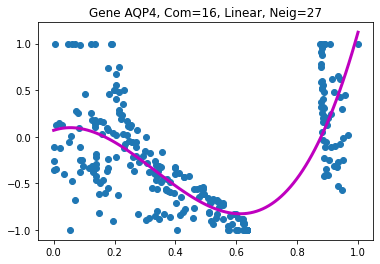

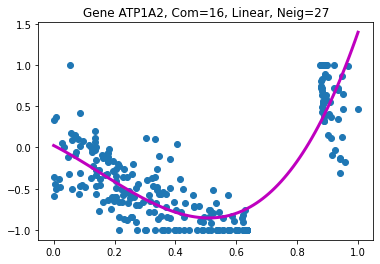

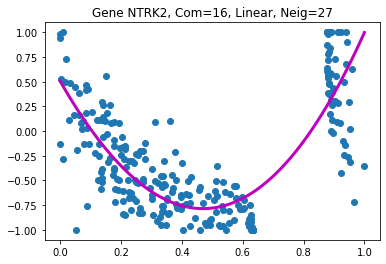

In [370]:
idx=np.argsort(pt_spectral)
figfile=f'{path_to_fig}Plotfilter{case}_{alpha}_comm_{commId}.pdf'

pp = PdfPages(figfile)
for g in geneplot:
    f=plt.figure()
    gene_series = data.loc[g][idx]
    fspline = UnivariateSpline(pt_spectral[idx], gene_series, check_finite=True)
    xtest = np.linspace(np.min(pt_spectral), np.max(pt_spectral), 100)
    fs = fspline(xtest)
    #plt spline
    plt.plot(xtest, fs, color='m', lw=3);
    #plot data
    plt.scatter(pt_spectral[idx],gene_series)
    plt.title("Gene " + g + ", Com="+str(commId) + ", "+ Flag + ', Neig=' +str(n_neighbors) )
    #f.savefig("commId1.pdf", bbox_inches='tight')
    pp.savefig(f)

pp.close()
    

# Get data for the community of interest - Non Linear Case

In [10]:
#Start from the linear communities
commId=NonLinearId[12]
Flag="Non Linear"
#communities=commInfo.index.values
#currentCFlag=commInfo.loc[communities==commId,'LinFlag']
comm = commData[commData.CommunityID == commId]
#select ONLY the genes in the selected community to use laterin the plot
genelist=comm.index.values

In [12]:
training_data=data.loc[comm.index]
nsamp=training_data.shape[1]
n_neighbors=math.ceil(nsamp/10)
n_neighbors
#n_neighbors=3 ####How to chose the number of neughbours?

27

In [11]:
commId

19

### Spectral pseudotime time


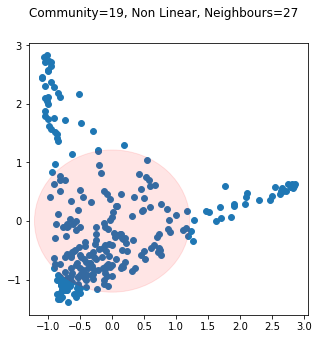

In [13]:
pt_spectral, latent_space_2d = estimate_pseudotime_using_spectral_embedding(training_data.T, n_neighbors)
[fig, ax] = plot_latent_space_notrue(latent_space_2d)
PseudoTimefile=f'{path_to_fig}NonLinearPseudotime{case}_{alpha}_comm_{commId}.pdf'

pt = PdfPages(PseudoTimefile)
fig.suptitle("Community="+str(commId) + ", "+ Flag + ', Neighbours=' +str(n_neighbors))
fig
pt.savefig(fig)

pt.close()

## Select genes to plot

You can modify `geneplot` to plot other genes

In [14]:
geneplot=genelist
#geneplot = ['ACTB', 'ACTG1', 'AGT', 'ANXA5']

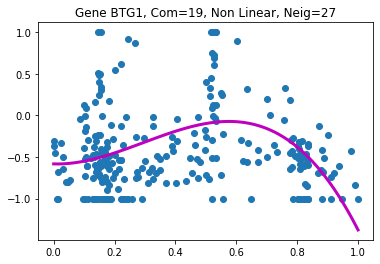

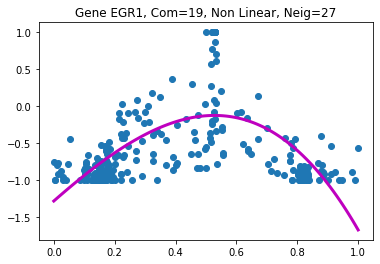

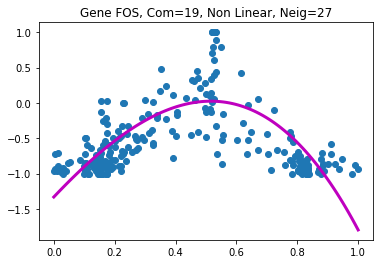

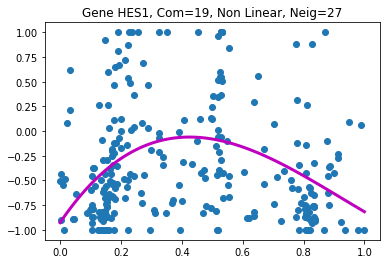

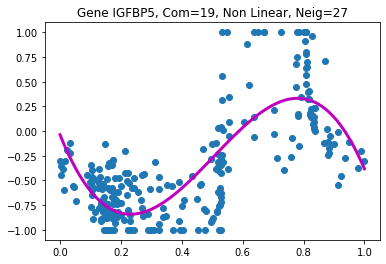

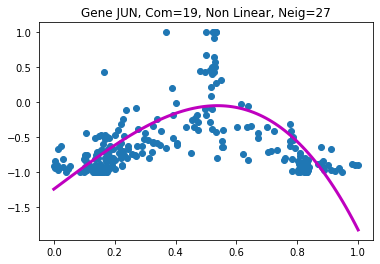

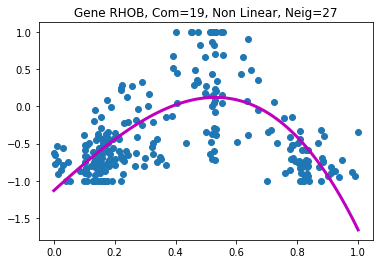

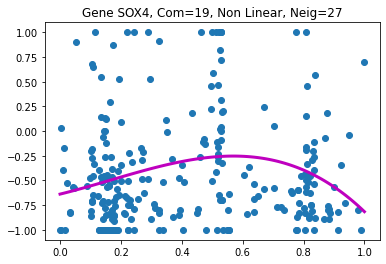

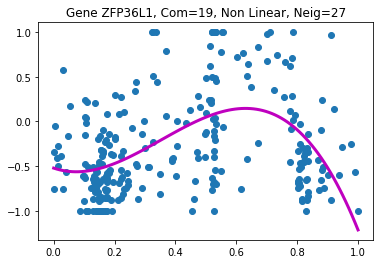

In [15]:
idx=np.argsort(pt_spectral)
figfile=f'{path_to_fig}Plotfilter{case}_{alpha}_comm_{commId}.pdf'

pp = PdfPages(figfile)
for g in geneplot:
    f=plt.figure()
    gene_series = data.loc[g][idx]
    fspline = UnivariateSpline(pt_spectral[idx], gene_series, check_finite=True)
    xtest = np.linspace(np.min(pt_spectral), np.max(pt_spectral), 100)
    fs = fspline(xtest)
    #plt spline
    plt.plot(xtest, fs, color='m', lw=3);
    #plot data
    plt.scatter(pt_spectral[idx],gene_series)
    plt.title("Gene " + g + ", Com="+str(commId) + ", "+ Flag + ', Neig=' +str(n_neighbors) )
    #f.savefig("commId1.pdf", bbox_inches='tight')
    pp.savefig(f)

pp.close()
    